In [1]:
# new model
# 1. 2D Eulerian model (for inert tracer) 
# 2. 1D slab model

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import scipy
from scipy import interpolate
from scipy.sparse import diags
import scipy.sparse as sp

import matplotlib.tri as tri
import matplotlib.pyplot as plt

PI = math.pi

In [2]:
# input value

# time step
Dt_2d = 15 # [s]
Dt_1d = 5  # [s]

# grid resolution
Dx = 200 # [m]
Dy = 20 # [m]

# grid number
Nx = 4000 #243 # 483
Ny = 300 #135 # 271

# define diffusion coefficient
Diff_x = 10.0 # [m2 s-1]
Diff_y = 0.5 # [m2 s-1]

# define a fixed wind field
U_shear = 0.002 # [s-1]

# initial total injected mass
Mass = 1.0e+8 # [kg]
AVO = 6.022e+23

# running time
time2 = 3600*48 # time for 1d model run

center: 2000 150
U.shape: (300, 4000)


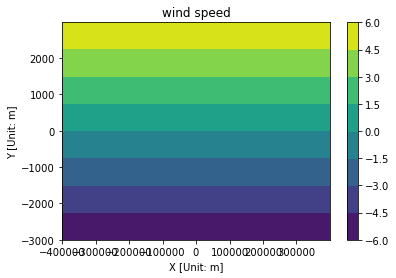

In [3]:
# For high resolution 2D Eulerian model
# for the first 24 hours

Ymax = Dy*Ny/2
Ymin = -Dy*Ny/2
Xmax = Dx*Nx/2
Xmin = -Dx*Nx/2


i_init = round(Nx/2)
j_init = round(Ny/2)
print('center:',i_init,j_init)

x = []
for i in range(Nx):
    x.append((i-i_init)*Dx)
    
y = []
for j in range(Ny):
    y.append((j-j_init)*Dy)

X, Y = np.meshgrid(x, y)


V = np.zeros([Ny,Nx]) # [m]
U = np.zeros([Ny,Nx])
print('U.shape:',U.shape)

for j in range(Ny):
    U[j,:] = Y[j,:] * U_shear # [m]
    
plt.contourf(X,Y,U)
plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'wind speed' )
plt.show()


100000000.0


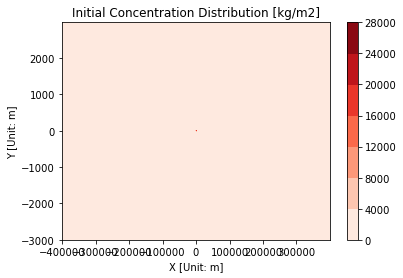

In [4]:
# define initial concentration distribution

Concnt = np.zeros([Ny,Nx])


Concnt[j_init,i_init] = Mass/(Dx*Dy) # [kg m-2]
# Concnt[j_init,i_init] = Concnt[j_init,i_init] / 1.0e+6 / 98.0 * AVO

Original = Concnt[j_init,i_init]*Dx*Dy
print(Original)

contours = plt.contourf(X, Y, Concnt, cmap='Reds')
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2]' )
plt.colorbar()


plt.show()

In [5]:
def Adv_Diff2(C, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny):
    C_new = C*0.0
    C2    = C*0.0

    i = Nx
    j = Ny
    
    alpha = Dt*U[:,1:Nx-1]/Dx
    C2[:,1:Nx-1] = C[:,1:Nx-1] - 0.5*alpha*(C[:,2:Nx]-C[:,0:Nx-2]) \
                          + 0.5*alpha**2*(C[:,2:Nx]-2*C[:,1:Nx-1]+C[:,0:Nx-2])
      
#     for j in range(0,Ny,1):
#         alpha = Dt*U[j,1]/Dx
#         C2[j,1:Nx-1] = C[j,1:Nx-1] - 0.5*alpha*(C[j,2:Nx]-C[j,0:Nx-2]) \
#                             + 0.5*alpha**2*(C[j,2:Nx]-2*C[j,1:Nx-1]+C[j,0:Nx-2])

    C_new[1:Ny-1,1:Nx-1] = C2[1:Ny-1,1:Nx-1] + \
                             Dt*( Diff_x*(C2[1:Ny-1,0:Nx-2]+C2[1:Ny-1,2:Nx]-2*C2[1:Ny-1,1:Nx-1])/(Dx*Dx) \
                                + Diff_y*(C2[0:Ny-2,1:Nx-1]+C2[2:Ny,1:Nx-1]-2*C2[1:Ny-1,1:Nx-1])/(Dy*Dy) )
    
    return C_new

In [6]:
# Test confusion CFL condition

if 2*Diff_y*Dt_2d/(Dy**2)>1:
    print('****************************************')
    print('WARNING: diff Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt_2d')
    print('****************************************')
    
if 2*Diff_x*Dt_2d/(Dx**2)>1:
    print('****************************************')
    print('WARNING: diff X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt_2d/Dx>1:
    print('****************************************')
    print('WARNING: adv X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [7]:
%%time

# time run
Nt           = int(3600*12/Dt_2d)
Judge_radian = (90-2)/180*PI # [radians]
Theta        = 0.0           # [radians]
Height       = 0.0           #[m]

for t in range(Nt):    
    Concnt = Adv_Diff2(Concnt, U, Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)
    
#    print(Concnt[j_init,:])
#    print(sum(map(sum, Concnt)))
    # if the long Vs. short radius is larger than 20:1, 
    # then stop 2D model, begin 1D model;
    # check this every one hour
    Theta = np.arctan( np.tan(Theta) + U_shear*Dt_2d ) # this one can be optimise
    Height = np.sqrt(Height**2 + 2*Diff_y*Dt_2d)
    if Theta>Judge_radian: # change to 1D model
        print(t*Dt_2d/3600)
        break

3.975
CPU times: user 38.6 s, sys: 17.7 s, total: 56.4 s
Wall time: 56.5 s


In [8]:
time1 = (t+1)*Dt_2d  # initial time for 1-D grids

<ipython-input-9-a8ac148b9828>:3: UserWarning: Log scale: values of z <= 0 have been masked
  contours = plt.contourf(X, Y, Concnt, levs, locator=ticker.LogLocator(), cmap='Reds')


0 0


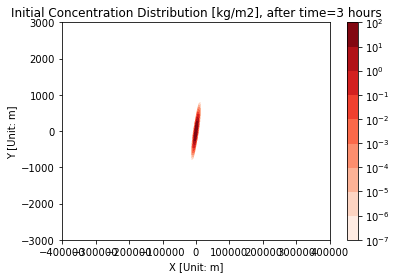

In [9]:

levs = (1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2)
# contours = plt.contourf(X, Y, Concnt, cmap='Reds')
contours = plt.contourf(X, Y, Concnt, levs, locator=ticker.LogLocator(), cmap='Reds')


plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)

plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2], after time='+str(int(time1/3600))+' hours' )
print(X[j_init,i_init],Y[j_init,i_init])

plt.show()


In [10]:
#########################################################
#
# 2D to 1D
#
##########################################################

In [11]:
# The function can calculate the scale length (Xscale, Yscale) 
# of the input concentration distribution (Concnt)

def Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac):
    
    M2d = Concnt*Dx*Dy
    total_mass = np.sum(M2d, axis=(0,1))
    
    Ysum = np.sum(M2d,axis=1) # sum along x axis
    Ysum_sort = sorted(Ysum, reverse=True)
    Ysum_cum = np.cumsum(Ysum_sort)
    numY = abs(Ysum_cum - frac*total_mass).argmin()
    Yscale = numY*Dy
    
    Xsum = np.sum(M2d,axis=0) # sum along x axis
    Xsum_sort = sorted(Xsum, reverse=True)
    Xsum_cum = np.cumsum(Xsum_sort)
    numX = abs(Xsum_cum - frac*total_mass).argmin()
    Xscale = numX*Dx
    
    return Xscale, Yscale

In [12]:
def tilt_C2d(Concnt, x, y, Dx, Dy, Nx, Ny, Theta, Na, Nb, LenA, LenB):
    
    # find the long and short radius given concentration distribution
    # build a 2D nest for integrationn
    Nb_mid = int(Nb/2)

    # interval in long radius
    Adx = LenA*np.sin(Theta)
    Ady = LenA*np.cos(Theta)

    # interval in short radius
    Bdy = LenB*np.sin(Theta)
    Bdx = LenB*np.cos(Theta)

    # define the location in 2D xy mesh used to determine initial concentration
    Y1d = np.zeros((Na,Nb))
    X1d = np.zeros((Na,Nb))

    print('Y1d.shape: ', Y1d.shape)

    # find the location of 1D grid in 2D XY grids
    for i in range(Na):
        X1d[i,Nb_mid] = -Adx*Na/2 + Adx*(i+0.5)   # ???
        Y1d[i,Nb_mid] = -Ady*Na/2 + Ady*(i+0.5)   # ???

    for j in range(Nb_mid+1, Nb, 1):
        X1d[:,j] = X1d[:,j-1] - Bdx
        Y1d[:,j] = Y1d[:,j-1] + Bdy
    
    for j in range(Nb_mid-1, -1, -1):
        X1d[:,j] = X1d[:,j+1] + Bdx
        Y1d[:,j] = Y1d[:,j+1] - Bdy

        
    # set the initial concentration for 1D
    C1d = np.zeros((Na,Nb))

    # Find the correct initial theta for 1D:
    F1       = interpolate.interp2d(x, y, Concnt, kind='linear')

    for i in range(Na):
        for j in range(Nb):
            if( abs(X1d[i,j])<abs(max(x)) or abs(Y1d[i,j])<abs(max(y)) ): # in case the tilt 2-D out ot range
                C1d[i,j] = F1( X1d[i,j], Y1d[i,j] )
        
    return C1d, X1d, Y1d

In [13]:
# define the length/width of slab based on a seconde order chamical reaction

def calc_LaLb(C1d, LenA, LenB):

    Prod = sum( np.square( C1d[Na_mid,:]) ) *(LenA*LenB)
    M    = sum( C1d[Na_mid,:] ) *(LenA*LenB)
    Lb   = LenB
    La   = M**2 /Prod / Lb
    
    return La, Lb

In [15]:
# calculate ScaleX and ScaleY containing 99%  of total mass

frac = 0.95
Xscale, Yscale = Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac)

Height = Yscale # refernce of the plume cross-section vertical scale for 1D initial
Length = Xscale

Theta = math.atan(Xscale/Yscale)
print(Height, Length, Theta)

math.degrees(math.atan(Xscale/Yscale))

460 7800 1.511890195948636


86.62492731506387

rotated 2-D mesh resolution: LenB, LenA:  20 200
rotated 2-D mesh grid number: Nb, Na:  600 60
Y1d.shape:  (60, 600)


<ipython-input-16-fe2a7ac24c7e>:27: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X1d, Y1d, C1d,  levs, locator=ticker.LogLocator(), cmap='Reds')


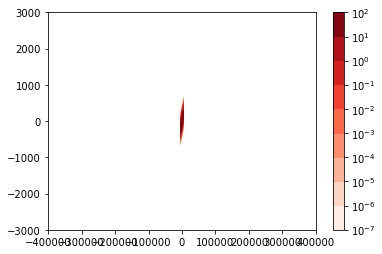

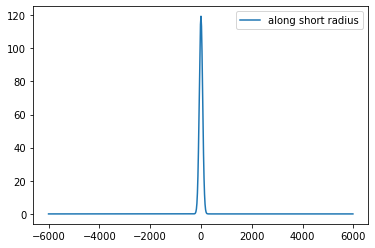

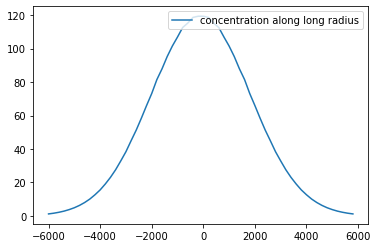

In [16]:
# 1D grid length
LenB = Dy # number is a arbitraty number
LenA = Dx #
print('rotated 2-D mesh resolution: LenB, LenA: ', LenB, LenA)

Nb = int(Height/Dy) # short radius
Nb = math.ceil(Nb/4)*4

Nb = Nb*25 # increase grid number in vertical direction

Na = int(1.5*Length/Dx) # long radius
Na = math.ceil(Na/4)*4
print('rotated 2-D mesh grid number: Nb, Na: ', Nb, Na)

Nb_25  = int(Nb/4)
Nb_mid = Nb_50 = int(Nb/4*2)
Nb_75  = int(Nb/4*3)

Na_25  = int(Na/4)
Na_mid = Na_50 = int(Na/4*2)
Na_75  = int(Na/4*3)

# calculate the concentration in rotated 2-D mesh:
C1d, X1d, Y1d = tilt_C2d(Concnt, x, y, Dx, Dy, Nx, Ny, Theta, Na, Nb, LenA, LenB)

# plt.contourf(X1d, Y1d, C1d, cmap='Reds')
plt.contourf(X1d, Y1d, C1d,  levs, locator=ticker.LogLocator(), cmap='Reds')
plt.colorbar()

plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)
plt.show()

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*LenB + LenB*i
    
plt.plot(leng-leng[Nb_mid], C1d[Na_mid,:], label='along short radius')
plt.legend()
plt.show()

leng2 = np.zeros(Na)
for i in range(Na):
    leng2[i] = 0.5*LenA + LenA*i
    
plt.plot(leng2-leng2[Na_mid], C1d[:,Nb_mid], label='concentration along long radius')
plt.legend(loc='upper right')
plt.show()



In [17]:
# Calculate the concentration given the La and Lb

# La, Lb = calc_LaLb(C1d, LenA, LenB)

La = Length
Lb = LenB

print(LenA, LenB)
print(La, Lb)

C_box = np.zeros(Nb)
for i in range(Nb):
    C_box[i] = sum(C1d[:,i]) *(LenA*LenB)/ (La*Lb)


200 20
7800 20


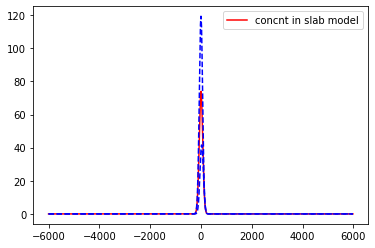

In [18]:
# for the 2nd phase: 1D model

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*LenB + LenB*i
    
plt.plot(leng-leng[Nb_mid], C_box, 'r', label='concnt in slab model')

plt.plot(leng-leng[Nb_mid], C1d[Na_mid,:], 'b--')
plt.plot(leng-leng[Nb_mid], C1d[Na_25,:], 'b--')

plt.legend()
plt.show()

In [19]:
# total mass check

total_mass = np.sum(Concnt, axis=(0,1))*Dx*Dy
Total_m1 = np.sum(C1d, axis=(0,1))*LenA*LenB
mass_1D = np.sum(C_box)*La*Lb

print(total_mass, Total_m1, mass_1D)
print((total_mass-mass_1D)/total_mass)

99999999.99999993 99598531.73409192 99598531.73409192
0.004014682659080031


In [20]:
##################################################################
#
# run 1D
#
##################################################################

In [21]:
# diffusion process
def Difussion2(C, Diff_y, Dt, Dy, Ny):
    C_diff = C*0.0
    
    C_diff[1:Ny-1] = C[1:Ny-1] + Dt*Diff_y*(C[0:Ny-2]+C[2:Ny]-2*C[1:Ny-1])/(Dy*Dy)
    
    return C_diff

In [22]:
print('Theta origin:',Theta)


Nt = int(time2/Dt_1d)

Diff_v = Diff_y
Diff_h = Diff_x

for it in range(Nt): 
    # shear effect:
    S = La*Lb
    Theta_old = Theta
    Theta = np.arctan( np.tan(Theta) + U_shear*Dt_1d )
    # La = La * (np.tan(Theta)**2+1)**0.5 / (np.tan(Theta_old)**2+1)**0.5
    La = La * (1 + U_shear**2 *Dt_1d**2 *np.cos(Theta)**2 + 2*U_shear*Dt_1d*np.sin(Theta)*np.cos(Theta) )**0.5
    Lb = S/La
    
    Theta1 = (Theta+Theta_old)/2
    Diff_b = Diff_v*np.sin(Theta1) + Diff_h*np.cos(Theta1)
    Diff_a = Diff_v*np.cos(Theta1) + Diff_h*np.sin(Theta1)
    
    # Test confusion CFL condition
    if 2*Diff_b*Dt_1d/(Lb**2)>1:
        print('****************************************')
        print('WARNING: diff Y: CFL condition is not satisfied')
        print('Combing grid to incease Dy')
        print('****************************************')
        
        print('time for combing slab (hours):', it*Dt_1d/3600, 'hour', 'Lb:', Lb)
        
        Lb = 2*Lb
        C_new = C_box*0.0
        for i in range(Nb_50):
            C_box[i] = 0.5* ( C_box[2*i]+C_box[2*i+1] )
        C_new[Nb_25-1:Nb_75-1] = C_box[0:Nb_50]
        C_box = C_new    
    
    
    # diffusion effect in short radius
    C_box = Difussion2(C_box, Diff_b, Dt_1d, Lb, Nb)
        
    # diffusion effect in long radius:
#    La_old = La
#    La = np.sqrt(La_old**2+2.0*Diff_a*Dt2)
#    C_box = C_box *La_old /La

    
    # divide plume cross-section into 5 segments once the cross-section is highly distorted
#    Judge_L = 2*110*1000 # [m]
#    if La>Judge_L:
print('Theta finish:',Theta)

Theta origin: 1.511890195948636
****************************************
Combing grid to incease Dy
****************************************
time for combing slab (hours): 17.4125 hour Lb: 2.3879117527699574
****************************************
Combing grid to incease Dy
****************************************
time for combing slab (hours): 38.50277777777778 hour Lb: 2.310818320504487
Theta finish: 1.5680381431623391


In [23]:
print(La,Lb)
print(La/Na)

166394.16835123516 3.7501314269790273
2773.236139187253


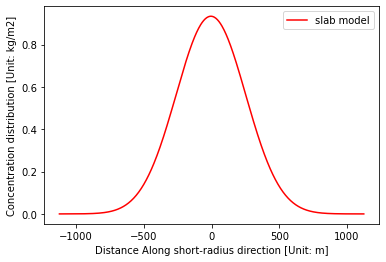

Original:  100000000.0
mass in 2D:  99999999.99999993
mass in 1D:  99015215.91814908


In [24]:
# plot

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*Lb + Lb*i

plt.plot(leng-Lb*Nb_50, C_box,'r',label='slab model')

#plt.ylim(0, 14)

plt.xlabel('Distance Along short-radius direction [Unit: m]')
plt.ylabel('Concentration distribution [Unit: kg/m2]')
plt.legend()
plt.show()


print('Original: ', Original)
print('mass in 2D: ', np.sum(Concnt, axis=(0,1))*Dx*Dy)
print('mass in 1D: ', np.sum(C_box)*La*Lb)

In [25]:
###############################################################################################################
#
# run 2-D for comparison
#
###############################################################################################################

In [26]:
# Test confusion CFL condition

if 2*Diff_y*Dt_2d/(Dy**2)>1:
    print('****************************************')
    print('WARNING: diff Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt_2d')
    print('****************************************')
    
if 2*Diff_x*Dt_2d/(Dx**2)>1:
    print('****************************************')
    print('WARNING: diff X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt_2d/Dx>1:
    print('****************************************')
    print('WARNING: adv X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [27]:
%%time

# for validation: Gaussian analytical results Vs. 1D slab model.

print('time1=', time1/3600, '(h); time2', time2/3600, 'h')
t_total = time1+time2

Concnt2 = Concnt

# time run
Nt           = int(time2/Dt_2d)

print(Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)

for t in range(Nt):
    Concnt2 = Adv_Diff2(Concnt2, U, Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)



time1= 3.9791666666666665 (h); time2 48.0 h
10.0 0.5 15 200 20 4000 300
CPU times: user 7min 47s, sys: 3min 12s, total: 11min
Wall time: 11min 1s


<ipython-input-28-4dc298637566>:2: UserWarning: Log scale: values of z <= 0 have been masked
  contours = plt.contourf(X, Y, Concnt2, levs, locator=ticker.LogLocator(), cmap='Reds')


[[-200    0  200]
 [-200    0  200]
 [-200    0  200]] [[-20 -20 -20]
 [  0   0   0]
 [ 20  20  20]] [[0.78438658 0.78412476 0.78384867]
 [0.78748065 0.78748787 0.78748065]
 [0.78384867 0.78412476 0.78438658]]
0 0 0.7874878711951455


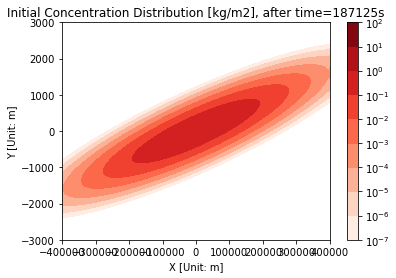

In [28]:

#contours = plt.contourf(X, Y, Concnt2, cmap='Reds')
contours = plt.contourf(X, Y, Concnt2, levs, locator=ticker.LogLocator(), cmap='Reds')



plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)

plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2], after time='+str(t_total)+'s' )
print(X[j_init-1:j_init+2,i_init-1:i_init+2],Y[j_init-1:j_init+2,i_init-1:i_init+2], \
      Concnt2[j_init-1:j_init+2,i_init-1:i_init+2])
print(X[j_init,i_init],Y[j_init,i_init], Concnt2[j_init,i_init])
plt.show()



In [29]:
# calculate ScaleX and ScaleY containing 99%  of total mass

Xscale2, Yscale2 = Get_XYscale(Concnt2, Dx, Dy, Nx, Ny, frac)

Height2 = Lb*Nb # Yscale2 # refernce of the plume cross-section vertical scale for 1D initial
Length2 = Xscale2

Theta2 = math.atan(Xscale2/Yscale2)
print(Height2, Length2, Theta2)
print('Theta & Theta2', Theta, Theta2)
math.degrees(math.atan(Xscale2/Yscale2))

2250.0788561874165 366200 1.5662087019613233
Theta & Theta2 1.5680381431623391 1.5662087019613233


89.73714845904685

LenB, LenA:  3.7501314269790273 200
Nb, Na:  600 1832
Y1d.shape:  (1832, 600)


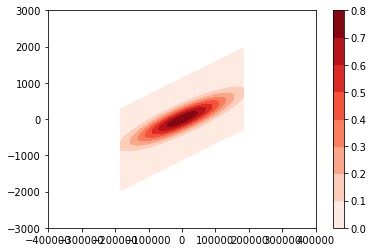

leng2.shape: (600,)
C1d2.shape: (1832, 600)


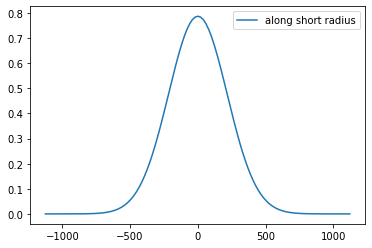

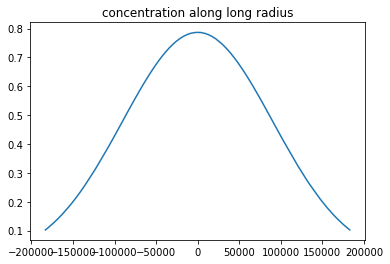

In [30]:
# 1D grid length

# LenB doesn't have big influence on final results
LenB2 = Lb # Dy # number is a arbitraty number
LenA2 = Dx #
print('LenB, LenA: ', LenB2, LenA2)

Nb2 = int(Height2/LenB2) # short radius
Nb2 = math.ceil(Nb2/4)*4

Na2 = int(Length2/Dx) # long radius
Na2 = math.ceil(Na2/4)*4
print('Nb, Na: ', Nb2, Na2)

Nb2_25  = int(Nb2/4)
Nb2_mid = Nb2_50 = int(Nb2/4*2)
Nb2_75  = int(Nb2/4*3)

Na2_25  = int(Na2/4)
Na2_mid = Na2_50 = int(Na2/4*2)
Na2_75  = int(Na2/4*3)


C1d2, X1d2, Y1d2 = tilt_C2d(Concnt2, x, y, Dx, Dy, Nx, Ny, Theta2, Na2, Nb2, LenA2, LenB2)

plt.contourf(X1d2, Y1d2, C1d2, cmap='Reds')

plt.colorbar()

plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)
plt.show()





leng2 = np.zeros(Nb2)
for i in range(Nb2):
    leng2[i] = 0.5*LenB2 + LenB2*i
print('leng2.shape:', leng2.shape)
print('C1d2.shape:', C1d2.shape)   

plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_mid,:], label='along short radius')
plt.legend()
plt.show()




leng2 = np.zeros(Na2)
for i in range(Na2):
    leng2[i] = 0.5*LenA2 + LenA2*i
    
plt.plot(leng2-leng2[Na2_mid], C1d2[:,Nb2_mid])
plt.title('concentration along long radius')
plt.show()


In [31]:
# Calculate the concentration given the La and Lb

#La2, Lb2 = calc_LaLb(C1d2, LenA2, LenB2)

La2 = La # Length2
Lb2 = Lb

#La2 = La # #######################################  important  #####

print(LenA2, LenB2)
print(La2, Lb2)

C_box2 = np.zeros(Nb2)
for i in range(Nb2):
    C_box2[i] = sum(C1d2[:,i]) *(LenA2*LenB2)/ (La2*Lb2)

200 3.7501314269790273
166394.16835123516 3.7501314269790273


In [32]:
print('Original: ', Original)
print('mass in 2D: ', np.sum(Concnt, axis=(0,1))*Dx*Dy)
print('mass in 1D: ', np.sum(C_box)*La*Lb)
print('mass in 2D again: ', np.sum(Concnt2, axis=(0,1))*Dx*Dy)
print('mass in 2D_to_1D for comparison:', np.sum(C_box2)*La2*Lb2)


Original:  100000000.0
mass in 2D:  99999999.99999993
mass in 1D:  99015215.91814908
mass in 2D again:  99998029.9297873
mass in 2D_to_1D for comparison: 94994023.91579036


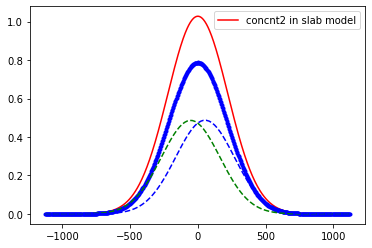

In [42]:
# for the 2nd phase: 1D model


leng2 = np.zeros(Nb2)
for i in range(Nb2):
    leng2[i] = 0.5*LenB2 + LenB2*i
    
plt.plot(leng2-leng2[Nb2_mid], C_box2, 'r', label='concnt2 in slab model')

plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_mid,:], 'b.')
plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_75,:], 'g--')
plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_25,:], 'b--')

plt.legend()
plt.show()

# ??? red line ???

No handles with labels found to put in legend.


La, Lb=166394.2, 3.8 & La2, lb2=166394.2, 3.8
La, Lb=166394.2, 3.8 & La2, lb2=166394.2, 3.8


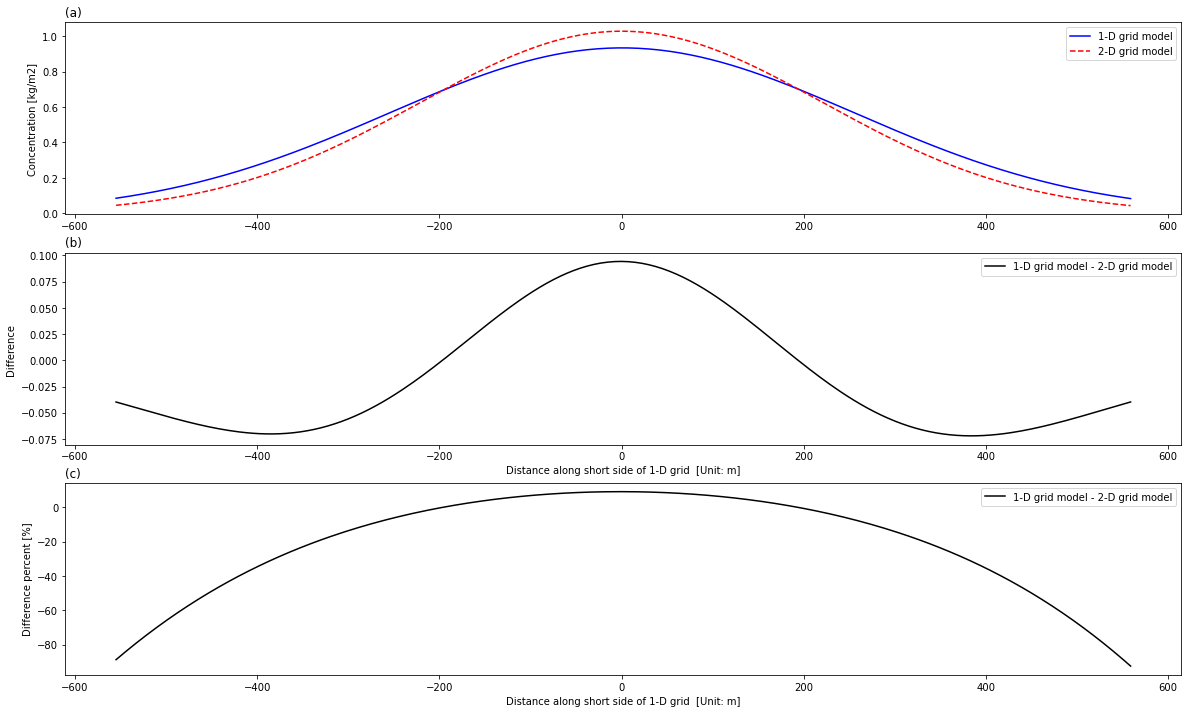

In [34]:
# plot

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*Lb + Lb*i
    

# plot
fig, ax = plt.subplots(3,figsize=(20,12))

ax[0].plot(leng[2+150:Nb-150]-leng[Nb_mid], C_box[0+150:Nb-2-150],'b',label='1-D grid model')
ax[0].plot(leng[2+150:Nb-150]-leng[Nb_mid], C_box2[2+150:Nb-150], 'r--', label='2-D grid model') # ???
# ax[0].plot(0*leng2,C_box2, 'k--')

ax[0].set_title('(a)', loc='left')
ax[0].set_ylabel('Concentration [kg/m2]')
# ax[0].set_xlim(-1000,1000)
ax[0].legend()



# plot concentratin difference
ax[1].plot(leng[2+150:Nb-150]-leng[Nb_mid], (C_box2[2+150:Nb-150]-C_box[0+150:Nb-2-150]),'k',\
           label='1-D grid model - 2-D grid model')
# ax[1].plot(0*leng2,C_box2, 'k--')

ax[1].set_title('(b)', loc='left')
ax[1].set_xlabel('Distance along short side of 1-D grid  [Unit: m]')
ax[1].set_ylabel('Difference ')
# ax[1].set_xlim(-1000,1000)
ax[1].legend()

#plt.ylim(0, 14)
print('La, Lb={:.1f}, {:.1f} & La2, lb2={:.1f}, {:.1f}'.format(La,Lb, La2, Lb2))
plt.legend()


# (c)
# plot concentratin difference
ax[2].plot(leng[2+150:Nb-150]-leng[Nb_mid], 100*(C_box2[2+150:Nb-150]-C_box[0+150:Nb-2-150])/C_box2[2+150:Nb-150],\
           'k', label='1-D grid model - 2-D grid model')
# ax[1].plot(0*leng2,C_box2, 'k--')

ax[2].set_title('(c)', loc='left')
ax[2].set_xlabel('Distance along short side of 1-D grid  [Unit: m]')
ax[2].set_ylabel('Difference percent [%]')
# ax[2].set_xlim(-1000,1000)
ax[2].legend()

#plt.ylim(0, 14)
print('La, Lb={:.1f}, {:.1f} & La2, lb2={:.1f}, {:.1f}'.format(La,Lb, La2, Lb2))
plt.show()


In [35]:

print('1D model hours:', time2/3600)

print('Original: ', Original)
print('mass in 2D: ', np.sum(Concnt2, axis=(0,1))*Dx*Dy)
print('mass in 1D: ', np.sum(C_box)*La*Lb)
print('La1D, Lb1D: ', La, Lb)
print('La2D, Lb2D: ', La2, Lb2)
print(f'time1={time1:0.4f}, time2={time2:0.4f}')

1D model hours: 48.0
Original:  100000000.0
mass in 2D:  99998029.9297873
mass in 1D:  99015215.91814908
La1D, Lb1D:  166394.16835123516 3.7501314269790273
La2D, Lb2D:  166394.16835123516 3.7501314269790273
time1=14325.0000, time2=172800.0000


In [36]:
a = (C_box2[2+180:Nb-180]-C_box[0+180:Nb-2-180])/C_box2[2+180:Nb-180]

In [37]:
a.max()

0.0916841004775468